In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");
colors = sns.color_palette()

# Example - Particle filters

We are going to first look at how we can solve the filtering problem with particle filters. Professor Bilionis has implemented jax-based code for particle filters in a package called [dax](https://github.com/PredictiveScienceLab/dax). We will be heavily leaning on this code to implement particle filters for the example problem, but please go through the code to understand how it works.

In [26]:
!pip install diffrax optax blackjax seaborn toml git+https://github.com/PredictiveScienceLab/dax.git

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/PredictiveScienceLab/dax.git to /private/var/folders/cm/5m6g5c890j5cwww5cq4_ydk00000gp/T/pip-req-build-vrq_n_tr
  Running command git clone --filter=blob:none --quiet https://github.com/PredictiveScienceLab/dax.git /private/var/folders/cm/5m6g5c890j5cwww5cq4_ydk00000gp/T/pip-req-build-vrq_n_tr
  Resolved https://github.com/PredictiveScienceLab/dax.git to commit 022ce93c3ce7929adcbb750ef70d5058b34e8a4b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [27]:
import dax
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import optax

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0)

### Stochastic Duffing Oscillator

Let's look at the stocahstic Duffing Oscillator. It is described by the following equation:

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t) + \sigma \xi(t)$$

where $\delta$, $\alpha$, $\beta$, $\gamma$, and $\omega$ are constants. 

In [28]:
# Define the right-hand side, deterministic part of the Duffing oscillator
class DuffingControl(dax.ControlFunction):

    omega: jax.Array

    def __init__(self, omega):
        self.omega = jnp.array(omega)
    
    def _eval(self, t):
        # This is to avoid training the parameter
        omega = jax.lax.stop_gradient(self.omega)
        return jnp.cos(omega * t)

# Define the stochastic differential equation
class Duffing(dax.StochasticDifferentialEquation):

    alpha: jax.Array
    beta: jax.Array
    delta: jax.Array

    gamma: jax.Array
    log_sigma_x: jax.Array
    log_sigma_v: jax.Array

    @property
    def sigma_x(self):
        return jnp.exp(self.log_sigma_x)

    @property
    def sigma_v(self):
        return jnp.exp(self.log_sigma_v)

    def __init__(self, alpha, beta, gamma, delta, sigma_x, sigma_v, u):
        super().__init__(control_function=u)
        self.alpha = jnp.array(alpha)
        self.beta = jnp.array(beta)
        self.delta = jnp.array(delta)

        self.gamma = jnp.array(gamma)
        self.log_sigma_x = jnp.log(sigma_x)
        self.log_sigma_v = jnp.log(sigma_v)
    
    def drift(self, x, u):
        # We won't train gamma
        gamma = jax.lax.stop_gradient(self.gamma)
        return jnp.array([x[1], -self.delta * x[1] - self.alpha * x[0] - self.beta * x[0] ** 3 + gamma * u])
    
    def diffusion(self, x, u):
        # We won't train sigma_x and sigma_v
        sigma_x = jax.lax.stop_gradient(self.sigma_x)
        sigma_v = jax.lax.stop_gradient(self.sigma_v)
        return jnp.array([sigma_x, sigma_v])

Let's introduce our parameters and define our stochastic Duffing oscillator:

In [29]:
omega = 1.2
alpha = -1.0
beta = 1.0
delta = 0.3
gamma = 0.5
sigma_x = 0.01
sigma_v = 0.05
u = DuffingControl(omega)
true_sde = Duffing(alpha, beta, gamma, delta, sigma_x, sigma_v, u)

Of course, we will need initial conditions

In [30]:
# True initial conditions
true_x0 = jnp.array([1.0, 0.0])

Recall that we do not directly observe the state of the system, but have noisy observations of the position, this is called the observation model, governed by emission probabilities. We will be assuming a Gaussian observation model.

In [31]:
# Observation model
observation_function = dax.SingleStateSelector(0)
# Observation variance
s = 0.1
true_likelihood = dax.GaussianLikelihood(s, observation_function)

Let's rewrite this as a system stochastic differential equations by introducing $X_1 = x$ and $X_2 = \dot{x}$:

$$
\begin{align*}
dX_1 & = X_2 \\
dX_2 & = (\gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3)dt + \sigma dW_t
\end{align*}
$$

To apply particle filter, we need a discrete-time state-space model. Let's discretize the system using the Euler-Maruyama method:

$$
\begin{align*}
X_{1,t} &= X_{1,t-\Delta t} + X_{2,t - \Delta t} \Delta t \\
X_{2,t} &= X_{2,t-\Delta t} + (\gamma \cos(\omega t - \Delta t) - \delta X_{2, t-\Delta t} - \alpha X_{1, t - \Delta t} - \beta X_{1, t - \Delta t}^3) \Delta t + \sigma \sqrt{\Delta t} Z_{t - \Delta t}
\end{align*}
$$

where $Z_t$ is a standard normal random variable.

Perfect, this forms our state-space model, we we will denote:

$$
x_t = \begin{bmatrix} x_t \\ v_t \end{bmatrix} = \begin{bmatrix} X_{1,t \Delta t} \\ X_{2,t \Delta t} \end{bmatrix}
$$

This state space model defines our transition probabilities:

$$
p(x_t | x_{t-1}, u_t) = \mathcal{N} \left(  x_t \left| \begin{bmatrix} x_{t-1} + v_{t-1} \Delta t \\ v_{t-1} + (\gamma \cos(\omega t - \Delta t) - \delta v_{t-1} - \alpha x_{t-1} - \beta x_{t-1}^3) \Delta t \end{bmatrix} \right. , \text{diag}(\sigma_x^2, \sigma_v^2) \Delta t \right)
$$

where $u_t$ is the control input:

$$
u_t = \omega \cos(\omega ((t-1) \Delta t))
$$

In [32]:
dt = 0.1
# Make the statespace model
x0 = dax.DiagonalGaussian(
    jnp.array([0.0, 0.0]),
    jnp.array([1.0, 1.0])
)
ssm = dax.StateSpaceModel(
    dax.DiagonalGaussian(
        jnp.array([0.0, 0.0]),
        jnp.array([1.0, 1.0])),
    dax.EulerMaruyama(true_sde, dt=dt),
    true_likelihood
)

Okay great, now that we have our state-space model, let's look at the data that we will be using to estimate the state of the system.

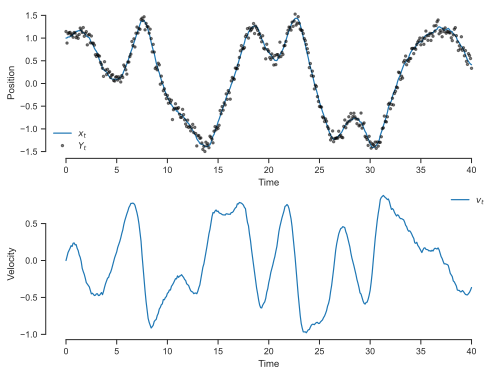

In [33]:
# Define the length of the simulation
t0 = 0.0
t1 = 40.0

# Generate synthetic data
sol = true_sde.sample_path(key, t0, t1, true_x0, dt=dt, dt0=0.05)
key, subkey = jr.split(key)
xs = sol.ys
ts = sol.ts
us = u(ts)
keys = jr.split(key, xs.shape[0])
ys = true_likelihood.sample(xs, us, keys)

# Plot the observed data
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Position plot
ax[0].plot(ts, xs[:, 0], label=r'$x_t$')
ax[0].plot(ts, ys[:, 0], 'k.', label=r'$Y_t$', alpha=0.5)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Position')
ax[0].legend(frameon=False)
sns.despine(ax=ax[0], trim=True)

# Velocity plot
ax[1].plot(ts, xs[:, 1], label=r'$v_t$')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].legend(frameon=False)
sns.despine(ax=ax[1], trim=True)

plt.show()


Okay great, let's use this data to filter our data using the dax implementation of the bootstrap filter. We will start by training the filter on the first half of the data. 

Filtering...


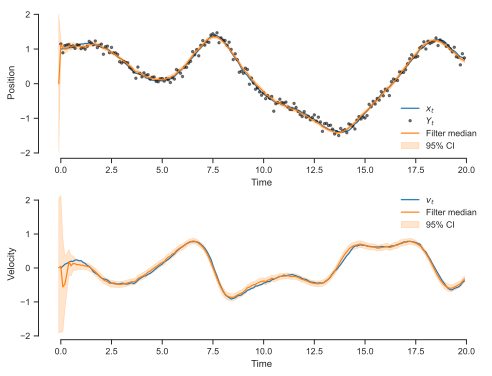

In [34]:
# Define what we will use for training data
t_train = 200
ts_train = ts[:t_train]
ts_train_w_init = jnp.concatenate([jnp.array([ts[0] - dt]), ts_train])
ys_train = ys[:t_train]
us_train = us[:t_train]

# Ready to do the filtering
num_particles = 10_000

print('Filtering...')
filter = dax.BootstrapFilter(num_particles=num_particles)
key, subkey = jr.split(key)
pas, log_L = filter.filter(ssm, us_train, ys_train, subkey)

key, subkey = jr.split(key)
lower, median, upper = pas.get_credible_interval(subkey)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Position plot
ax[0].plot(ts_train, xs[:t_train, 0], label=r'$x_t$')
ax[0].plot(ts_train, ys_train[:, 0], 'k.', label=r'$Y_t$', alpha=0.5)
ax[0].plot(ts_train_w_init, median[:, 0], label='Filter median')
ax[0].fill_between(ts_train_w_init, lower[:, 0], upper[:, 0], alpha=0.2, color=colors[1], label='95% CI')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Position')
ax[0].legend(frameon=False)
sns.despine(ax=ax[0], trim=True)

# Velocity plot
ax[1].plot(ts_train, xs[:t_train, 1], label=r'$v_t$')
ax[1].plot(ts_train_w_init, median[:, 1], label='Filter median')
ax[1].fill_between(ts_train_w_init, lower[:, 1], upper[:, 1], alpha=0.2, color=colors[1], label='95% CI')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].legend(frameon=False)
sns.despine(ax=ax[1], trim=True)
plt.show()


Okay, great! We have reconstructed the observed AND hidden states of the system using the particle filter. Recall from lecture the discussion about how the credible interval shrinks as we add more data. What if you increase the variance of the observation model? How big can you make it and still get a good estimate of the hidden state?

We can now use this to make predictions about the future states of the system.

Predicting...


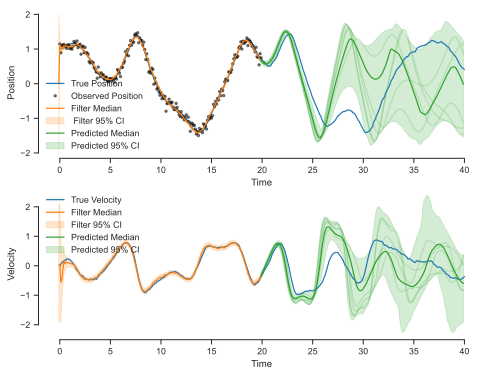

In [49]:
# Test data
ts_test = ts[t_train-1:-1]
us_test = us[t_train:]

# Predict the future
print('Predicting...')
key, subkey = jr.split(key)
pas_test = ssm.predict(pas[-1], us_test, subkey)

key, subkey = jr.split(key)
lower_test, median_test, upper_test = pas_test.get_credible_interval(subkey)

end_particles = int(num_particles / 5)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Position plot
ax[0].plot(ts, xs[:, 0], label='True Position')
ax[0].plot(ts_train, ys_train[:, 0], 'k.', label='Observed Position', alpha=0.5)
ax[0].plot(ts_train_w_init, median[:, 0], label='Filter Median')
ax[0].fill_between(ts_train_w_init, lower[:, 0], upper[:, 0], alpha=0.2, color=colors[1], label=' Filter 95% CI')
ax[0].plot(ts_test, median_test[:, 0], color=colors[2], label='Predicted Median')
ax[0].fill_between(ts_test, lower_test[:, 0], upper_test[:, 0], alpha=0.2, color=colors[2], label='Predicted 95% CI')
ax[0].plot(ts_test, pas_test.particles[:, 0::end_particles, 0], color=colors[2], alpha=0.2)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Position')
ax[0].legend(frameon=False)
sns.despine(ax=ax[0], trim=True)

# Velocity plot
ax[1].plot(ts, xs[:, 1], label='True Velocity')
ax[1].plot(ts_train_w_init, median[:, 1], label='Filter Median')
ax[1].fill_between(ts_train_w_init, lower[:, 1], upper[:, 1], alpha=0.2, color=colors[1], label='Filter 95% CI')
ax[1].plot(ts_test, median_test[:, 1], color=colors[2], label='Predicted Median')
ax[1].fill_between(ts_test, lower_test[:, 1], upper_test[:, 1], alpha=0.2,  color=colors[2], label='Predicted 95% CI')
ax[1].plot(ts_test, pas_test.particles[:, 0::end_particles, 1], color=colors[2], alpha=0.2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].legend(frameon=False)
sns.despine(ax=ax[1], trim=True)
plt.show()


Okay, we can see that the particle filter predictions fail to capture the true state of the system when some time has passed since the observations. Try playing around with the number of partcles and the time step size to see if you can improve the predictions.